In [1]:
import sys, os

import numpy as np
import pandas as pd

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, t

src_path = os.path.abspath(os.path.join('../src'))
sys.path.append(src_path)

from data import get_data, meta, OUTPUT_CHARTS, RAW_DATA
from plots import *

In [2]:
sns.set()

In [3]:
fig_folder = OUTPUT_CHARTS + '/ucs'
data = get_data()

data = data[data["descartados_ucs"] == 0] 

In [4]:
display(data.groupby("litologia")['ucs'].describe()[['count', 'min', 'max', 'mean', 'std']].round(2))

,count,min,max,mean,std
litologia,,,,,
Basalto Maciço,19.0,93.00,262.4,168.31,49.96
Basalto Vesiculado,3.0,19.97,121.3,56.76,56.08
Basalto Brechado,2.0,34.30,80.5,57.40,32.67
Basalto Hidrotermal,1.0,101.50,101.5,101.50,NaN
Peperito,4.0,32.50,93.9,51.55,28.92
Riolito,1.0,148.00,148.0,148.00,NaN
Arenito,1.0,16.30,16.3,16.30,NaN


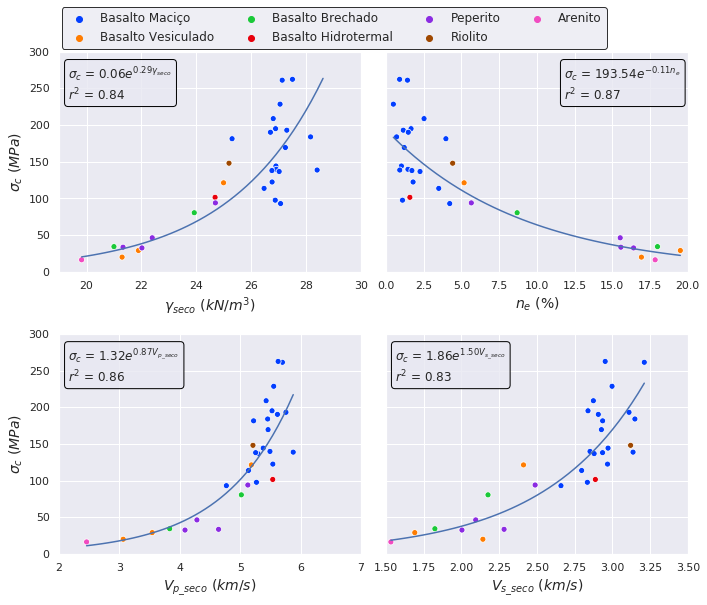

In [5]:
figure, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)

y = 'ucs'
metay = meta[y]
formula = 'np.log(%s) ~ %s'

x = 'p_esp_seco'
ax = plot_reg(x, y, data, ax=axes[0][0], log_y=True)
ax.get_legend().remove()

result = ols(formula=formula % (y, x), data=data).fit()
text = '$%s$ = %.2f$ e^{%.2f %s}$ \n$r^2$ = %.2f' % (metay['symbol'],np.exp(result.params[0]), result.params[1], meta[x]['symbol'], result.rsquared)
props = dict(boxstyle='round', facecolor=(0.91, 0.91, 0.95, 0.8), edgecolor='black')
ax.text(0.03, 0.94, text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)


x = 'porosidade_efetiva'
ax = plot_reg(x, y, data, ax=axes[0][1], log_y=True)
ax.get_legend().remove()

result = ols(formula=formula % (y, x), data=data).fit()
text = '$%s$ = %.2f$ e^{%.2f %s}$ \n$r^2$ = %.2f' % (metay['symbol'],np.exp(result.params[0]), result.params[1], meta[x]['symbol'], result.rsquared)
props = dict(boxstyle='round', facecolor=(0.91, 0.91, 0.95, 0.8), edgecolor='black')
ax.text(0.59, 0.94, text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)


x = 'vp_seco'
ax = plot_reg(x, y, data, ax=axes[1][0], log_y=True)
ax.get_legend().remove()

result = ols(formula=formula % (y, x), data=data).fit()
text = '$%s$ = %.2f$ e^{%.2f %s}$ \n$r^2$ = %.2f' % (metay['symbol'],np.exp(result.params[0]), result.params[1], meta[x]['symbol'], result.rsquared)
props = dict(boxstyle='round', facecolor=(0.91, 0.91, 0.95, 0.8), edgecolor='black')
ax.text(0.03, 0.94, text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)


x = 'vs_seco'
ax = plot_reg(x, y, data, ax=axes[1][1], log_y=True)
ax.get_legend().remove()

result = ols(formula=formula % (y, x), data=data).fit()
text = '$%s$ = %.2f$ e^{%.2f %s}$ \n$r^2$ = %.2f' % (metay['symbol'],np.exp(result.params[0]), result.params[1], meta[x]['symbol'], result.rsquared)
props = dict(boxstyle='round', facecolor=(0.91, 0.91, 0.95, 0.8), edgecolor='black')
ax.text(0.03, 0.94, text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

plt.tight_layout()

ax = axes[0][0]
handles, labels = ax.get_legend_handles_labels()
idx = labels.index('litologia')
labels.pop(idx), handles.pop(idx)
ax.legend(handles=handles, labels=labels, prop={'size': 12}, frameon=True, edgecolor='black', bbox_to_anchor=(-0.01, 1.23), ncol=4, loc='upper left')

plt.savefig('%s/ucs_correlations.png' % fig_folder, bbox_inches='tight', dpi=150)
plt.show()

In [6]:
x = ['p_esp_seco', 'vp_seco']

model_data = data.copy()
model_data['teor_umidade'] = np.log(model_data['teor_umidade'])
model_data = model_data.drop(['GB02-05' for i in range(x.count('vs_seco'))])   

# outliers 
#model_data = data[[y, 'litologia', *x]].drop(['CB05-02', 'MA02-02'])

formula = 'np.log(%s) ~ %s' % (y, ' + '.join(x))
#formula = 'np.log(%s) ~ %s' % (y, ' + '.join(['np.log(%s)' % v for v in x]))

## Non-standardized regression
result_5 = ols(formula=formula, data=model_data).fit()
to_display = [result_5.summary()]

## Tests for multicolinearity
if len(x) > 1:
    
    ## Standardized regression
    std_data = model_data.copy()
    for var in x:
        std_data[var] = (std_data[var] - std_data[var].mean()) / std_data[var].std()

    result_5_std = ols(formula=formula, data=std_data).fit()
    #to_display.append(result_5_std.summary())

    ## VIF
    vif = pd.DataFrame([variance_inflation_factor(std_data[x].values, i) for i in range(len(x))], columns=['VIF'], index=[x])
    to_display.append(vif)
    

f_test_ss = pd.DataFrame([
    [result_5.df_model, result_5.ess, result_5.ess/result_5.df_model],
    [result_5.df_resid, result_5.ssr, result_5.ssr/result_5.df_resid],
    [result_5.df_resid + result_5.df_model, result_5.ssr + result_5.ess],
], columns=['df', 'sum_of_squares', 'mean_square'], index=['regression', 'residuals', 'total'])
to_display.append(f_test_ss)
    
display(multi_table(to_display))

In [7]:
alpha = 0.05
prediction = np.log(model_data[[y]]).join(result_5.get_prediction().summary_frame(alpha=alpha))
prediction['resid'] = prediction[y] - prediction['mean']
prediction['std_resid'] = result_5.get_influence().resid_studentized_internal
#prediction['std_resid'] = result_5.resid_pearson

back_prediction = np.exp(prediction)

prediction = prediction.join(model_data['litologia'])
back_prediction = back_prediction.join(model_data['litologia'])

In [8]:
prev_factors = []
for alpha in np.arange(0.05, 1, 0.05):
    pred = np.exp(result_5.get_prediction().summary_frame(alpha=alpha))
    
    conf_level = '%.0f%%' % ((1 - alpha) * 100)
    factor_inf = ols(formula='obs_ci_lower ~ mean', data=pred).fit().params[1]
    factor_sup = ols(formula='obs_ci_upper ~ mean', data=pred).fit().params[1]
    prev_factors.append([conf_level, factor_inf, factor_sup, alpha])

prev_factors = pd.DataFrame(prev_factors, columns=['conf_level', 'lower_factor', 'upper_factor', 'alpha'])
prev_factors['lower_factor'] = np.round(prev_factors['lower_factor'], 3)
prev_factors['upper_factor'] = np.round(prev_factors['upper_factor'], 3)
prev_factors = prev_factors.set_index('alpha')
display(prev_factors)

,conf_level,lower_factor,upper_factor
alpha,,,
0.05,95%,0.597,1.674
0.10,90%,0.652,1.534
0.15,85%,0.689,1.451
0.20,80%,0.719,1.391
0.25,75%,0.744,1.344
0.30,70%,0.767,1.304
0.35,65%,0.787,1.270
0.40,60%,0.806,1.240
0.45,55%,0.825,1.213


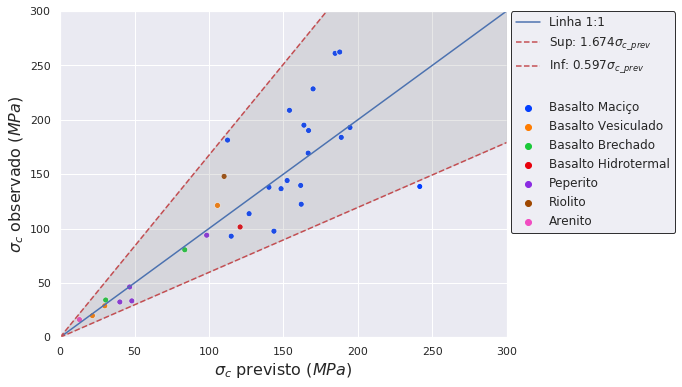

In [10]:
limits = np.array([0, 300])

f, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(x=limits, y=limits, ax=ax, label='Linha 1:1')
sns.scatterplot(x='mean', y=y, data=back_prediction, hue='litologia', palette='bright', ax=ax)

## prediction interval
alpha = 0.05
lower_fac = prev_factors.loc[alpha]['lower_factor']
lower = limits * lower_fac

upper_fac = prev_factors.loc[alpha]['upper_factor']
upper = limits * upper_fac

lb = '%.3f${%s}_{\_prev}}$'
ax.plot(limits, upper, 'r--', label='Sup: ' + lb % (upper_fac, metay['symbol']))
ax.plot(limits, lower, 'r--', label='Inf: ' + lb % (lower_fac, metay['symbol']))
ax.fill_between(limits,  lower,  upper, color='#888888', alpha=0.2)

ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xlabel('$%s$ previsto ($%s$)' % (metay['symbol'], metay['unit']), fontsize=16)
ax.set_ylabel('$%s$ observado ($%s$)' % (metay['symbol'], metay['unit']), fontsize=16)
legend = ax.legend(prop={'size': 12}, frameon=True, edgecolor='black', loc=(1.01, 0.32))
legend.texts[3].set_text('')

plt.savefig('%s/ucs_model_prediction.png' % (fig_folder), bbox_inches='tight', dpi=140)
plt.show()

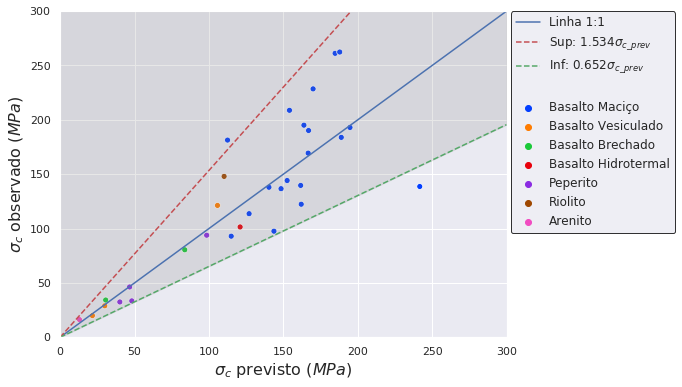

In [12]:
limits = np.array([0, 300])
alpha = 0.10

f, ax = plt.subplots(1, 1, figsize=(8, 6))

sns.lineplot(x=limits, y=limits, ax=ax, label='Linha 1:1')
sns.scatterplot(x='mean', y=y, data=back_prediction, hue='litologia', palette='bright', ax=ax)

## prediction interval
lower_fac = prev_factors.loc[alpha]['lower_factor']
lower = limits * lower_fac

upper_fac = prev_factors.loc[alpha]['upper_factor']
upper = limits * upper_fac

lb = '%.3f${%s}_{\_prev}}$'
ax.plot(limits, upper, 'r--', label='Sup: ' + lb % (upper_fac, metay['symbol']))
ax.plot(limits, lower, 'g--', label='Inf: ' + lb % (lower_fac, metay['symbol']))

ax.fill_between(limits,  lower,  [300, 300], color='#888888', alpha=0.2)

ax.set_xlim(limits)
ax.set_ylim(limits)
ax.set_xlabel('$%s$ previsto ($%s$)' % (metay['symbol'], metay['unit']), fontsize=16)
ax.set_ylabel('$%s$ observado ($%s$)' % (metay['symbol'], metay['unit']), fontsize=16)
legend = ax.legend(prop={'size': 12}, frameon=True, edgecolor='black', loc=(1.01, 0.32))
legend.texts[3].set_text('')

plt.savefig('%s/ucs_pred_conf_80.png' % (fig_folder), bbox_inches='tight', dpi=120)
plt.show()

,ucs,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper,resid,std_resid,litologia
codigo,,,,,,,,,,


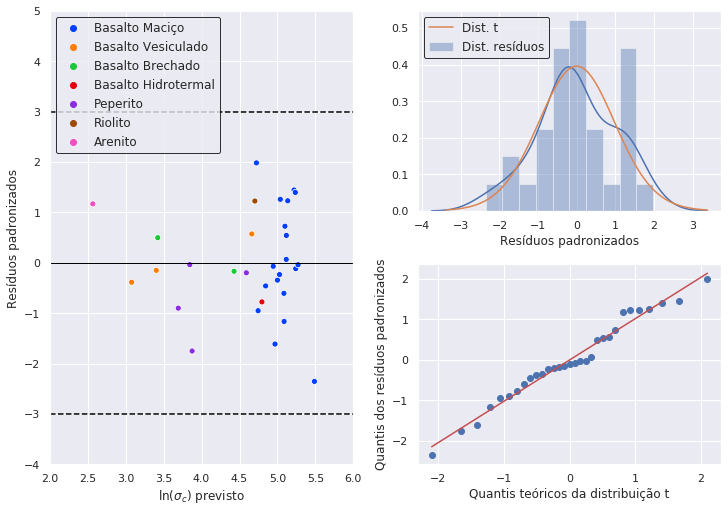

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(10, 7))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

## Standardized Residuals
ax = ax1
sns.scatterplot(x='mean', y='std_resid', data=prediction, hue='litologia', palette='bright', ax=ax)

ax.axhline(3, ls='--', c='black')
ax.axhline(-3, ls='--', c='black')
ax.set_xlim(2, 6)
ax.set_ylim(-4, 5)
ax.axhline(linewidth=1, color='black')
ax.set_xlabel('ln($\sigma_c$) previsto')
ax.set_ylabel('Resíduos padronizados')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], prop={'size': 12}, frameon=True, edgecolor='black', loc=2)

outliers = prediction[prediction['std_resid'].abs() >= 3]
display(outliers)


## Histogram
ax = ax2
sns.distplot(prediction['std_resid'], ax=ax, bins=10, label='Dist. resíduos')

df = result_5.nobs-1
t_dist = np.linspace(t.ppf(0.001, df), t.ppf(0.999, df), 100)
sns.lineplot(x=t_dist, y=t.pdf(t_dist, df), ax=ax, label='Dist. t')

ax.set_xlabel('Resíduos padronizados')
ax.legend(prop={'size': 12}, frameon=True, edgecolor='black', loc=2)


## Q-Q plot
ax = ax3
probplot(prediction['std_resid'], dist=t, sparams=(df), fit=False, plot=ax)
ax.set_title('')
ax.set_xlabel('Quantis teóricos da distribuição t')
ax.set_ylabel('Quantis dos resíduos padronizados')

plt.savefig('%s/ucs_residuals.png' % (fig_folder), bbox_inches='tight', dpi=200)
plt.show()

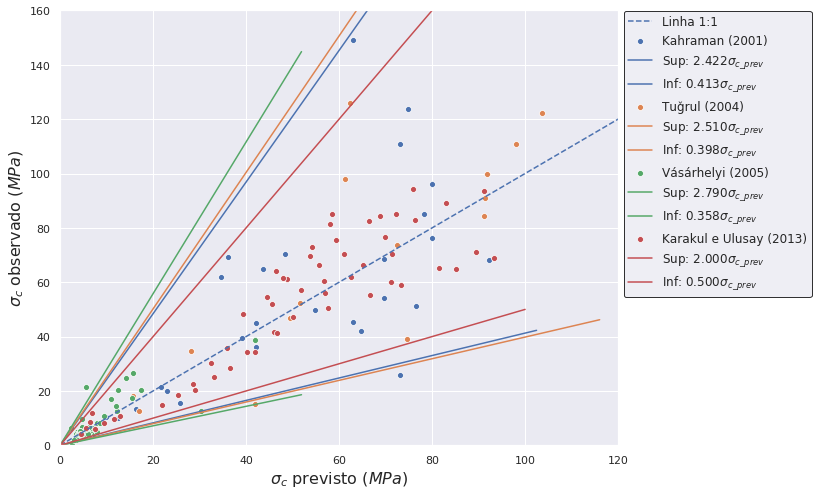

In [14]:
biblio_data = pd.read_csv(RAW_DATA + '/ucs_bibliografia.csv', sep=';').set_index('ref').drop(['karakul_ulusay_2013'])

f, ax = plt.subplots(1, 1, figsize=(10, 8))

formulas = dict(
    tugrul_2004 = 'np.log(ucs_obs) ~ var',
    kallu_roghanchi_2015 = 'np.log(ucs_obs) ~ np.log(var)',
    kahraman_2001 = 'np.log(ucs_obs) ~ np.log(var)',
    vasarhelyi_2005 = 'np.log(ucs_obs) ~ var',
    karakul_ulusay_2013 = 'np.log(ucs_obs) ~ np.log(var)',
)

lb = '%.3f${%s}_{\_prev}}$'
metaucs = meta['ucs']

ax.plot([0, 160], [0, 160], '--b', label='Linha 1:1')

for ref, ref_data in biblio_data.groupby(['ref']):
    result = ols(formula=formulas[ref], data=ref_data).fit()
    summary = np.exp(result.get_prediction().summary_frame())
    
    factor_inf = ols(formula='obs_ci_lower ~ mean', data=summary).fit().params[1]
    factor_sup = ols(formula='obs_ci_upper ~ mean', data=summary).fit().params[1]    
    
    limits = pd.Series([0, summary['mean'].max() + 10])

    color = next(ax._get_lines.prop_cycler)['color']
    
    sns.lineplot(x=limits, y=limits * factor_sup, ax=ax, label='Sup: ' + lb % (factor_sup, metaucs['symbol']), c=color)
    sns.lineplot(x=limits, y=limits * factor_inf, ax=ax, label='Inf: ' + lb % (factor_inf, metaucs['symbol']), c=color)
    
    sns.scatterplot(x='ucs_pred', y='ucs_obs', data=ref_data, ax=ax, c=[color], label=ref_data['referencia'].unique()[0])

    
biblio_data = pd.read_csv(RAW_DATA + '/ucs_bibliografia.csv', sep=';').set_index('ref').loc['karakul_ulusay_2013']
color = next(ax._get_lines.prop_cycler)['color']
sns.lineplot(x=[0, 100], y=[0, 200], ax=ax, label='Sup: ' + lb % (2, metaucs['symbol']), c=color)
sns.lineplot(x=[0, 100], y=[0, 50], ax=ax, label='Inf: ' + lb % (0.5, metaucs['symbol']), c=color)

sns.scatterplot(x='ucs_pred', y='ucs_obs', data=biblio_data, ax=ax, c=[color], label=biblio_data['referencia'].unique()[0])

ax.set_xlim([0, 120])
ax.set_ylim([0, 160])
ax.set_xlabel('$%s$ previsto ($%s$)' % (metaucs['symbol'], metaucs['unit']), fontsize=16)
ax.set_ylabel('$%s$ observado ($%s$)' % (metaucs['symbol'], metaucs['unit']), fontsize=16)

handles, labels = ax.get_legend_handles_labels()
handles = [
    handles[0],
    handles[9], *handles[1:3],
    handles[10], *handles[3:5],
    handles[11], *handles[5:7],
    handles[12], *handles[7:9],
]
labels = [
    labels[0],
    labels[9], *labels[1:3],
    labels[10], *labels[3:5],
    labels[11], *labels[5:7],
    labels[12], *labels[7:9],
]
ax.legend(handles=handles, labels=labels, prop={'size': 12}, frameon=True, edgecolor='black', loc=(1.01, 0.34))

plt.savefig('%s/ucs_biblio.png' % (fig_folder), bbox_inches='tight', dpi=120)
plt.show()